In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 12)

In [10]:
spy = yf.download('SPY', start='2015-01-01', end='2022-11-11')['Adj Close']
spy.name = 'SPY'
spy_ret = np.log(spy/spy.shift(1)).dropna()
spx_comp = pd.read_csv('./data/spx_data.csv', header=[0, 1], index_col=0, parse_dates=True)
spx_comp_close = spx_comp['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
year = '2016'
next_year = '2021'
stock = 80
spy_test = spy.loc[year:next_year]
stock_test = spx_comp_close.loc[year:next_year].iloc[:,stock]
month_list = spy_test.index.to_period('M').unique()
week_list = spy_test.index.to_period('W').unique()

In [4]:
arb_port = pd.DataFrame(columns=[stock_test.name, 'SPY'])
beta_list = []
short_sig_dfs = pd.DataFrame()
long_sig_dfs = pd.DataFrame()
short_pos_df = pd.DataFrame()
long_pos_df = pd.DataFrame()

cur_short_sig = 0
cur_long_sig = 0

open_short = -2
close_short = -1
open_long = 2
close_long = 1

reg_period = 52

for t in range(reg_period, len(week_list)):
    reg_week_cond = ((stock_test.index >= week_list[t-reg_period].to_timestamp())
                      & (stock_test.index <= week_list[t-1].to_timestamp('W')))
    stock_week = stock_test[reg_week_cond]
    spy_week = spy_test[reg_week_cond]

    y = np.log(stock_week / stock_week[0])
    X = add_constant(np.log(spy_week / spy_week[0]))
    coint_reg = OLS(y, X).fit()
    beta_list.append([week_list[t], coint_reg.params['SPY']])
    
    resid_week_cond = ((stock_test.index >= week_list[t].to_timestamp())
                        & (stock_test.index <= week_list[t].to_timestamp('W')))
    stock_resid = stock_test[resid_week_cond]
    spy_resid = spy_test[resid_week_cond]
    stock_pred = coint_reg.params['SPY'] * np.log(spy_resid / spy_week[0]) + coint_reg.params['const']
    resid = np.log(stock_resid / stock_week[0]) - stock_pred
    s_resid = resid / coint_reg.resid.std()
    
    if adfuller(coint_reg.resid)[0] < -3:

        resid_open_short = s_resid < open_short
        resid_close_short = s_resid > close_short
        open_short_sig = ((resid_open_short - resid_open_short.shift()).fillna(0) == 1) * 1
        close_short_sig = ((resid_close_short - resid_close_short.shift()).fillna(0) == 1) * -1

        short_sig_df = pd.concat([open_short_sig, close_short_sig], axis=1)
        short_sig_dfs = pd.concat([short_sig_dfs, short_sig_df])

        short_sig = []
        for row in short_sig_df.iterrows():
            if row[1].sum() == 1 and cur_short_sig == 0: 
                cur_short_sig = 1
            elif row[1].sum() == -1 and cur_short_sig == 1: 
                cur_short_sig = 0
            short_sig.append(cur_short_sig)
        short_pos = pd.Series(short_sig, index=short_sig_df.index, name='short')
        short_pos_df = pd.concat([short_pos_df, short_pos])

        resid_open_long = s_resid > open_long
        resid_close_long = s_resid < close_long
        open_long_sig = ((resid_open_long - resid_open_long.shift()).fillna(0) == 1) * 1
        close_long_sig = ((resid_close_long - resid_close_long.shift()).fillna(0) == 1) * -1

        long_sig_df = pd.concat([open_long_sig, close_long_sig], axis=1)
        long_sig_dfs = pd.concat([long_sig_dfs, long_sig_df])

        long_sig = []
        for row in long_sig_df.iterrows():
            if row[1].sum() == 1 and cur_long_sig == 0: 
                cur_long_sig = 1
            elif row[1].sum() == -1 and cur_long_sig == 1: 
                cur_long_sig = 0
            long_sig.append(cur_long_sig)
        long_pos = pd.Series(long_sig, index=long_sig_df.index, name='long')
        long_pos_df = pd.concat([long_pos_df, long_pos])
        
    else:
        
        cur_short_sig = 0
        cur_long_sig = 0
        short_pos = pd.Series(np.full(len(s_resid), 0), index=s_resid.index)
        long_pos = pd.Series(np.full(len(s_resid), 0), index=s_resid.index)
    
    resid_pos = long_pos - short_pos
    stock_pos = resid_pos
    spy_pos = -resid_pos * coint_reg.params['SPY']
    arb_port_week = pd.concat([stock_pos, spy_pos], axis=1)
    arb_port_week.columns = [stock_week.name, 'SPY']
    arb_port = pd.concat([arb_port, arb_port_week])
    
arb_port = arb_port.shift().fillna(0)

In [6]:
arb_sig = arb_port.diff().fillna(0)
port_val = 1000000
cash_val = port_val
cur_stock_pos = 0
cur_spy_pos = 0
arb_port_val = []

for t in arb_sig.index:
    cur_stock_pos += arb_sig.loc[t][stock_test.name]
    cur_spy_pos += arb_sig.loc[t]['SPY']
    stock_val = cur_stock_pos * stock_test.loc[t]
    spy_val = cur_spy_pos * spy_test.loc[t]
    cash_val -= arb_sig.loc[t][stock_test.name] * stock_test.loc[t] + arb_sig.loc[t]['SPY'] * spy_test.loc[t]
    port_val = cash_val + stock_val + spy_val
    arb_port_val.append([cash_val, stock_val, spy_val])
    
arb_port_val = pd.DataFrame(arb_port_val, index=arb_sig.index, columns=['Cash', stock_test.name, 'SPY'])

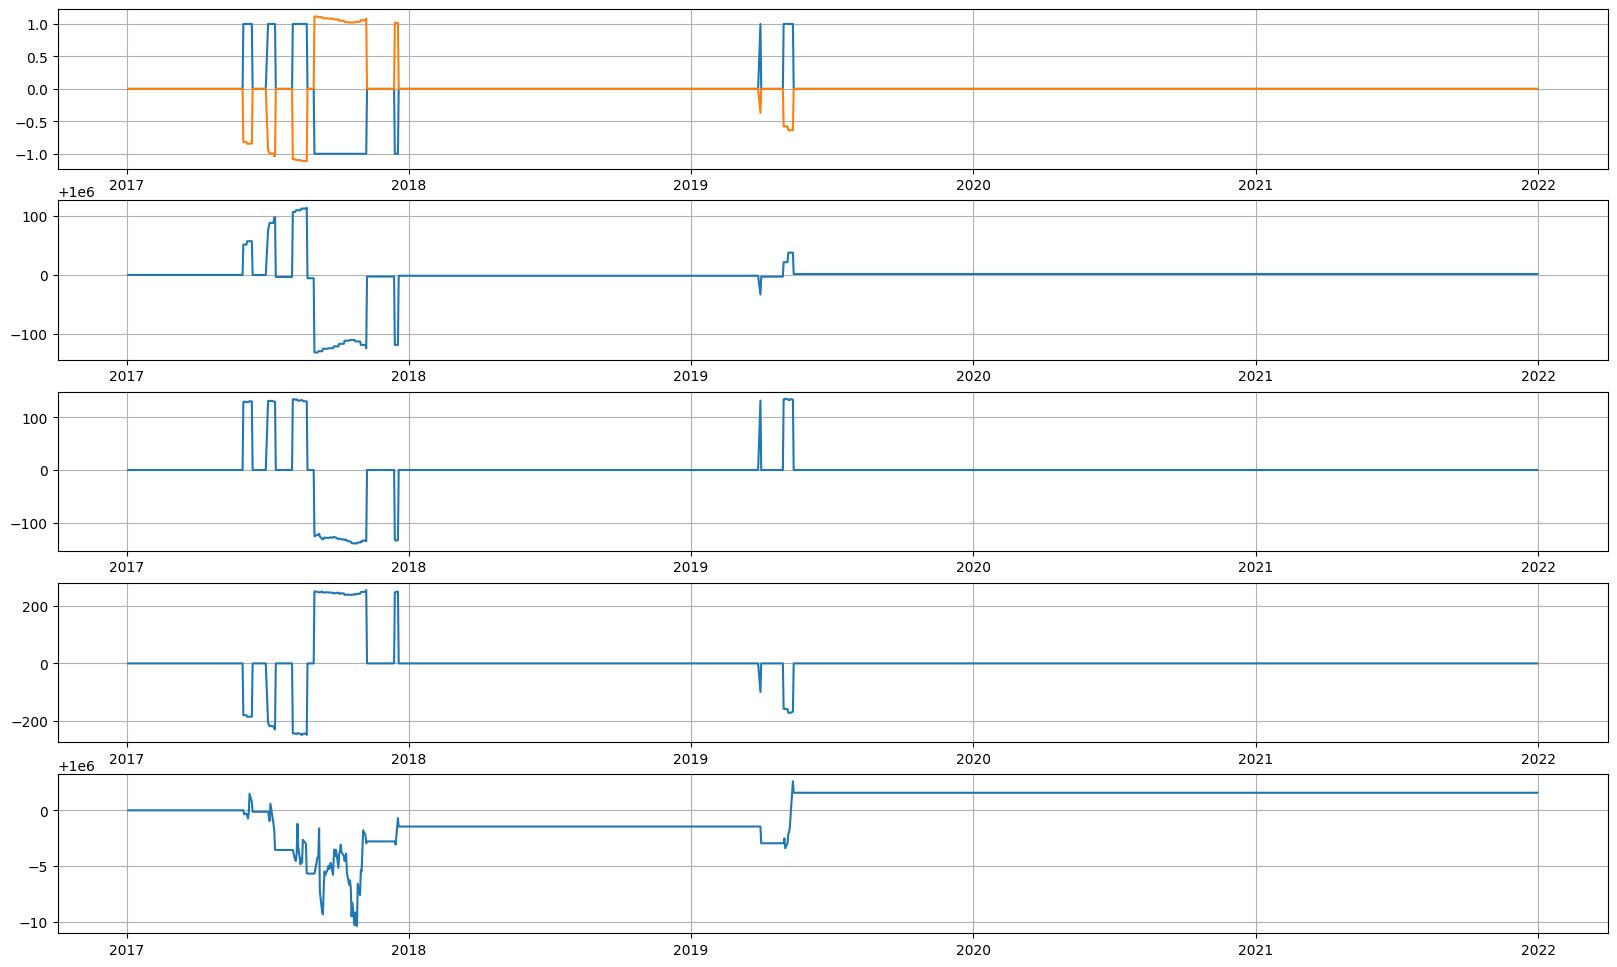

In [7]:
fig, axs = plt.subplots(5)
axs[0].plot(arb_port)
axs[1].plot(arb_port_val['Cash'])
axs[2].plot(arb_port_val[stock_test.name])
axs[3].plot(arb_port_val['SPY'])
axs[4].plot(arb_port_val.sum(axis=1))
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()

In [8]:
arb_sig = arb_port.diff().fillna(0)
port_val = 100000
cash_val = port_val
cur_stock_pos = 0
cur_spy_pos = 0
arb_port_val = []

for t in arb_sig.index:
    if arb_sig.loc[t][stock_test.name] == 1:
        if cur_stock_pos == 0:
            pos = np.abs(port_val / (stock_test.loc[t] - 0.5*arb_sig.loc[t]['SPY']*spy_test.loc[t]))
            cur_stock_pos += pos
            cur_spy_pos += arb_sig.loc[t]['SPY'] * pos
            cash_val -= pos * stock_test.loc[t] + arb_sig.loc[t]['SPY'] * pos * spy_test.loc[t]
        else:
            cash_val += cur_stock_pos * stock_test.loc[t] + cur_spy_pos * spy_test.loc[t]
            cur_stock_pos = 0
            cur_spy_pos = 0
    elif arb_sig.loc[t][stock_test.name] == -1:
        if cur_stock_pos == 0:
            pos = np.abs(port_val / (0.5*stock_test.loc[t] + arb_sig.loc[t]['SPY']*spy_test.loc[t]))
            cur_stock_pos -= pos
            cur_spy_pos += arb_sig.loc[t]['SPY'] * pos
            cash_val += pos * stock_test.loc[t] - arb_sig.loc[t]['SPY'] * pos * spy_test.loc[t]
        else:
            cash_val += cur_stock_pos * stock_test.loc[t] + cur_spy_pos * spy_test.loc[t]
            cur_stock_pos = 0
            cur_spy_pos = 0
    elif arb_sig.loc[t]['SPY'] != 0:
        cur_spy_pos += arb_sig.loc[t]['SPY'] * np.abs(cur_stock_pos)
        cash_val -= arb_sig.loc[t]['SPY'] * np.abs(cur_stock_pos) * spy_test.loc[t]
    stock_val = cur_stock_pos * stock_test.loc[t]
    spy_val = cur_spy_pos * spy_test.loc[t]
    port_val = cash_val + stock_val + spy_val
    arb_port_val.append([cash_val, stock_val, spy_val])
    
arb_port_val = pd.DataFrame(arb_port_val, index=arb_sig.index, columns=['Cash', stock_test.name, 'SPY'])

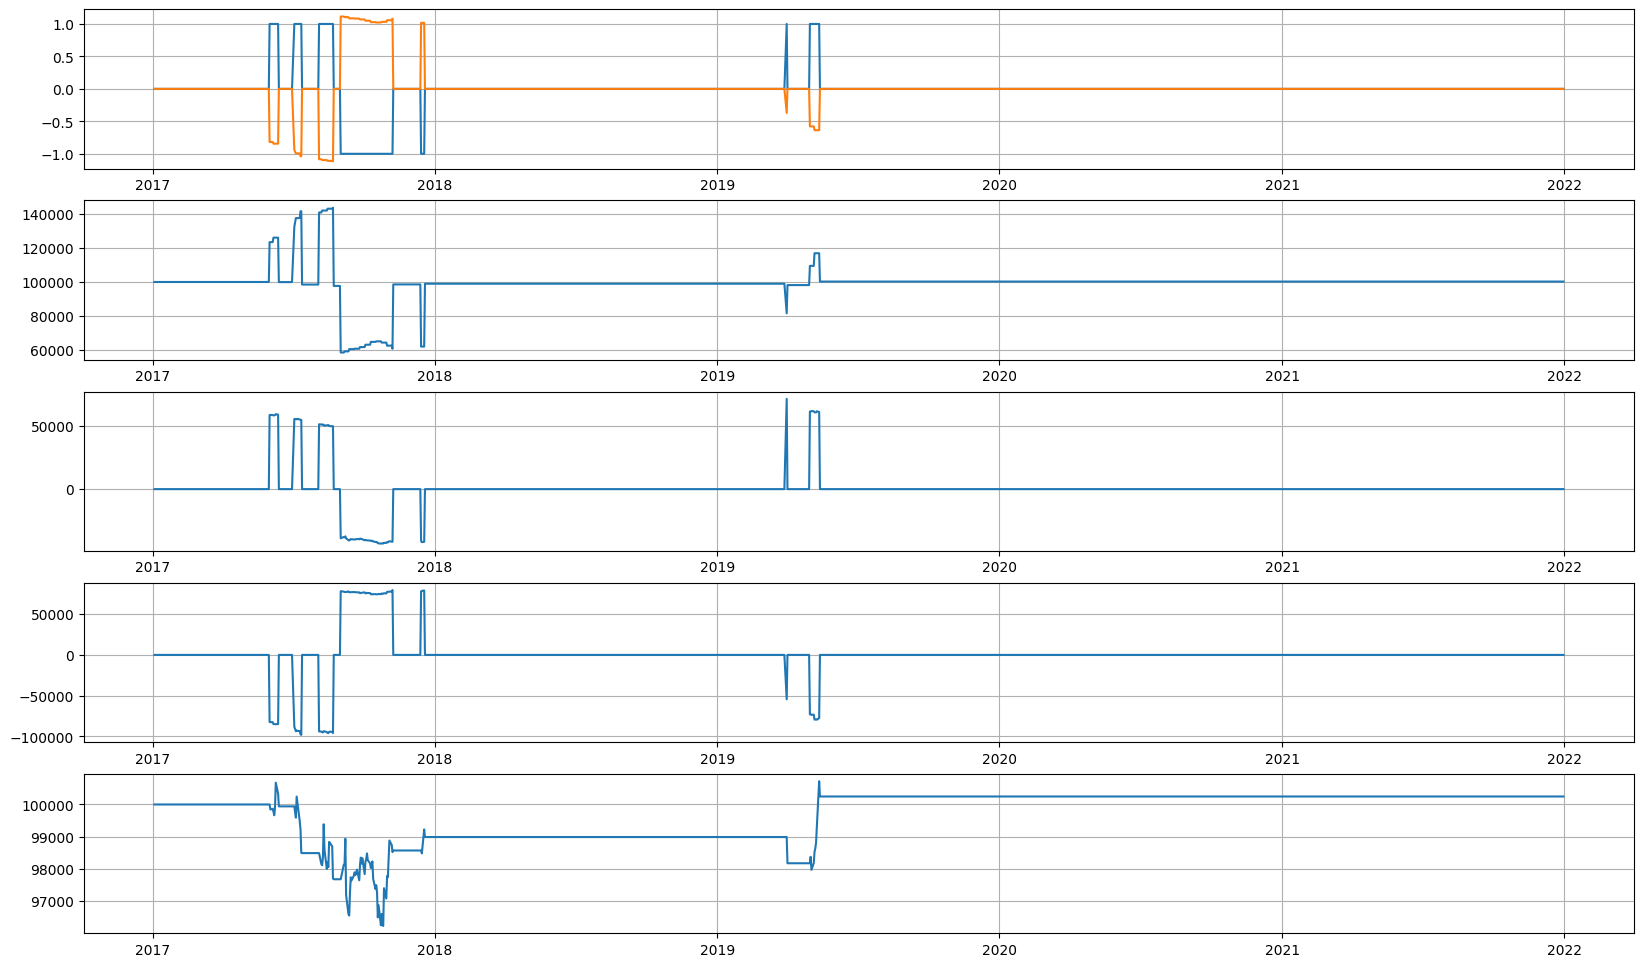

In [9]:
fig, axs = plt.subplots(5)
axs[0].plot(arb_port)
axs[1].plot(arb_port_val['Cash'])
axs[2].plot(arb_port_val[stock_test.name])
axs[3].plot(arb_port_val['SPY'])
axs[4].plot(arb_port_val.sum(axis=1))
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()